# Brain MRI Image Masking for Tumor Classification

This notebook implements skull stripping and brain masking techniques to improve the performance of brain tumor classification models. It processes MRI images to focus on the relevant brain tissue regions and remove non-brain areas that might affect model performance.

# 1. Import Required Libraries

Let's import all the necessary libraries for image processing and visualization.

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from skimage.morphology import binary_closing, binary_opening, disk
from tqdm.notebook import tqdm
from pathlib import Path

# For displaying images inline in notebook
%matplotlib inline
# Set the style using seaborn
sns.set_style("whitegrid")

# 2. Setup Image Loading and Paths

Define the paths for input and output directories, and create functions to load and process images.

In [ ]:
# Set up paths
TRAIN_PATH = Path(r"C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Train")
TEST_PATH = Path(r"C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\Test")

MASK_CACHE_PATH = Path(r"C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\mask_cache\train")
MASK_CACHE_PATH = Path(r"C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\mask_cache\test")

# Create mask cache directory if it doesn't exist
for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
    (MASK_CACHE_PATH / class_name).mkdir(parents=True, exist_ok=True)

def load_image(image_path):
    """Load and preprocess an image."""
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# 3. Create Brain Mask Function

Implement functions to create binary masks for brain region segmentation using thresholding and morphological operations.

In [13]:
def create_brain_mask(image):
    """Create a binary mask for brain region with improved skull removal and boundary smoothing."""
    # Normalize image to 0-255
    image = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)
    
    # Apply Otsu's thresholding
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Create structuring elements for morphological operations
    selem_main = disk(5)  # Main structuring element for initial mask
    selem_clean = disk(2)  # Smaller element for fine cleaning
    
    # Apply morphological operations to clean up the mask
    mask = binary_closing(binary_opening(binary > 0, selem_main), selem_main)
    
    # Convert to uint8
    mask = (mask * 255).astype(np.uint8)
    
    # Find contours and keep only the largest one (brain region)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(mask)
        cv2.drawContours(mask, [largest_contour], -1, 255, -1)
    
    # Create kernels for additional morphological operations
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    kernel_smooth = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    
    # Erode slightly to remove skull remnants
    mask = cv2.erode(mask, kernel_erode, iterations=1)
    
    # Smooth boundaries
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_smooth)
    
    return mask

def apply_mask(image, mask):
    """Apply the mask to the original image with improved edge handling."""
    # Ensure both image and mask are the same size
    if image.shape != mask.shape:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    
    # Create a slightly dilated mask for edge smoothing
    kernel_edge = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    edge_mask = cv2.dilate(mask, kernel_edge, iterations=1)
    inner_mask = cv2.erode(mask, kernel_edge, iterations=1)
    edge_zone = cv2.subtract(edge_mask, inner_mask)
    
    # Apply masks
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    # Smooth edges using edge zone
    edge_pixels = cv2.bitwise_and(image, image, mask=edge_zone)
    edge_pixels = cv2.GaussianBlur(edge_pixels, (3,3), 0)
    
    # Combine inner region with smoothed edges
    final_image = cv2.add(
        cv2.bitwise_and(masked_image, masked_image, mask=cv2.bitwise_not(edge_zone)),
        edge_pixels
    )
    
    return final_image

# 4. Image Preprocessing Functions

Define functions for image preprocessing, including normalization and contrast enhancement.

In [14]:
def adjust_gamma(image, gamma=1.0):
    """Adjust gamma of the image."""
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(image, table)

def correct_bias_field(image):
    """Approximate bias field correction using local contrast enhancement."""
    # Convert to float32
    img_float = image.astype(np.float32) / 255.0
    
    # Apply large-kernel gaussian blur to estimate bias field
    bias_field = cv2.GaussianBlur(img_float, (99, 99), 0)
    bias_field = np.maximum(bias_field, 0.01)  # Avoid division by zero
    
    # Correct bias field
    corrected = img_float / bias_field
    
    # Normalize to 0-255 range
    corrected = exposure.rescale_intensity(corrected, out_range=(0, 1))
    corrected = (corrected * 255).astype(np.uint8)
    
    return corrected

def preprocess_image(image):
    """Preprocess the image with improved bias correction and contrast enhancement."""
    # Convert to float for processing
    image_float = image.astype(float)
    
    # Initial normalization
    image_norm = (image_float - image_float.min()) / (image_float.max() - image_float.min())
    image_norm = (image_norm * 255).astype(np.uint8)
    
    # Apply bias field correction
    image_bias_corrected = correct_bias_field(image_norm)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_clahe = clahe.apply(image_bias_corrected)
    
    # Apply gamma correction
    image_gamma = adjust_gamma(image_clahe, gamma=1.2)
    
    # Denoise
    image_denoised = cv2.fastNlMeansDenoising(image_gamma)
    
    return image_denoised

def process_single_image(image_path, output_path):
    """Process a single image and save the masked version."""
    # Load and preprocess image
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)
    
    # Create and apply mask
    mask = create_brain_mask(preprocessed_image)
    masked_image = apply_mask(preprocessed_image, mask)
    
    # Save the masked image
    cv2.imwrite(str(output_path), masked_image)

# 5. Batch Processing

Process all images in the training dataset and save their masked versions.

In [15]:
def process_all_images():
    """Process all images in the training dataset."""
    # Process each class
    for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
        print(f"Processing {class_name} images...")
        
        # Create input and output paths
        input_dir = TRAIN_PATH / class_name
        output_dir = MASK_CACHE_PATH / class_name
        
        # Get all images in the input directory
        image_files = list(input_dir.glob('*.jpg')) + list(input_dir.glob('*.png'))
        total_images = len(image_files)
        
        print(f"Found {total_images} images in {class_name}")
        
        # Process each image with simple progress tracking
        for i, img_path in enumerate(image_files, 1):
            output_path = output_dir / img_path.name
            try:
                process_single_image(img_path, output_path)
                if i % 10 == 0:  # Print progress every 10 images
                    print(f"Processed {i}/{total_images} images in {class_name}")
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        
        print(f"Completed processing {class_name} images\n")

# Run the batch processing
process_all_images()

Processing glioma images...
Found 3325 images in glioma
Processed 10/3325 images in glioma
Processed 10/3325 images in glioma
Processed 20/3325 images in glioma
Processed 20/3325 images in glioma
Processed 30/3325 images in glioma
Processed 30/3325 images in glioma
Processed 40/3325 images in glioma
Processed 40/3325 images in glioma
Processed 50/3325 images in glioma
Processed 50/3325 images in glioma
Processed 60/3325 images in glioma
Processed 60/3325 images in glioma
Processed 70/3325 images in glioma
Processed 70/3325 images in glioma
Processed 80/3325 images in glioma
Processed 80/3325 images in glioma
Processed 90/3325 images in glioma
Processed 90/3325 images in glioma
Processed 100/3325 images in glioma
Processed 100/3325 images in glioma
Processed 110/3325 images in glioma
Processed 110/3325 images in glioma
Processed 120/3325 images in glioma
Processed 120/3325 images in glioma
Processed 130/3325 images in glioma
Processed 130/3325 images in glioma
Processed 140/3325 images 

# 6. Visualization and Verification

Display some example images to verify the masking process.

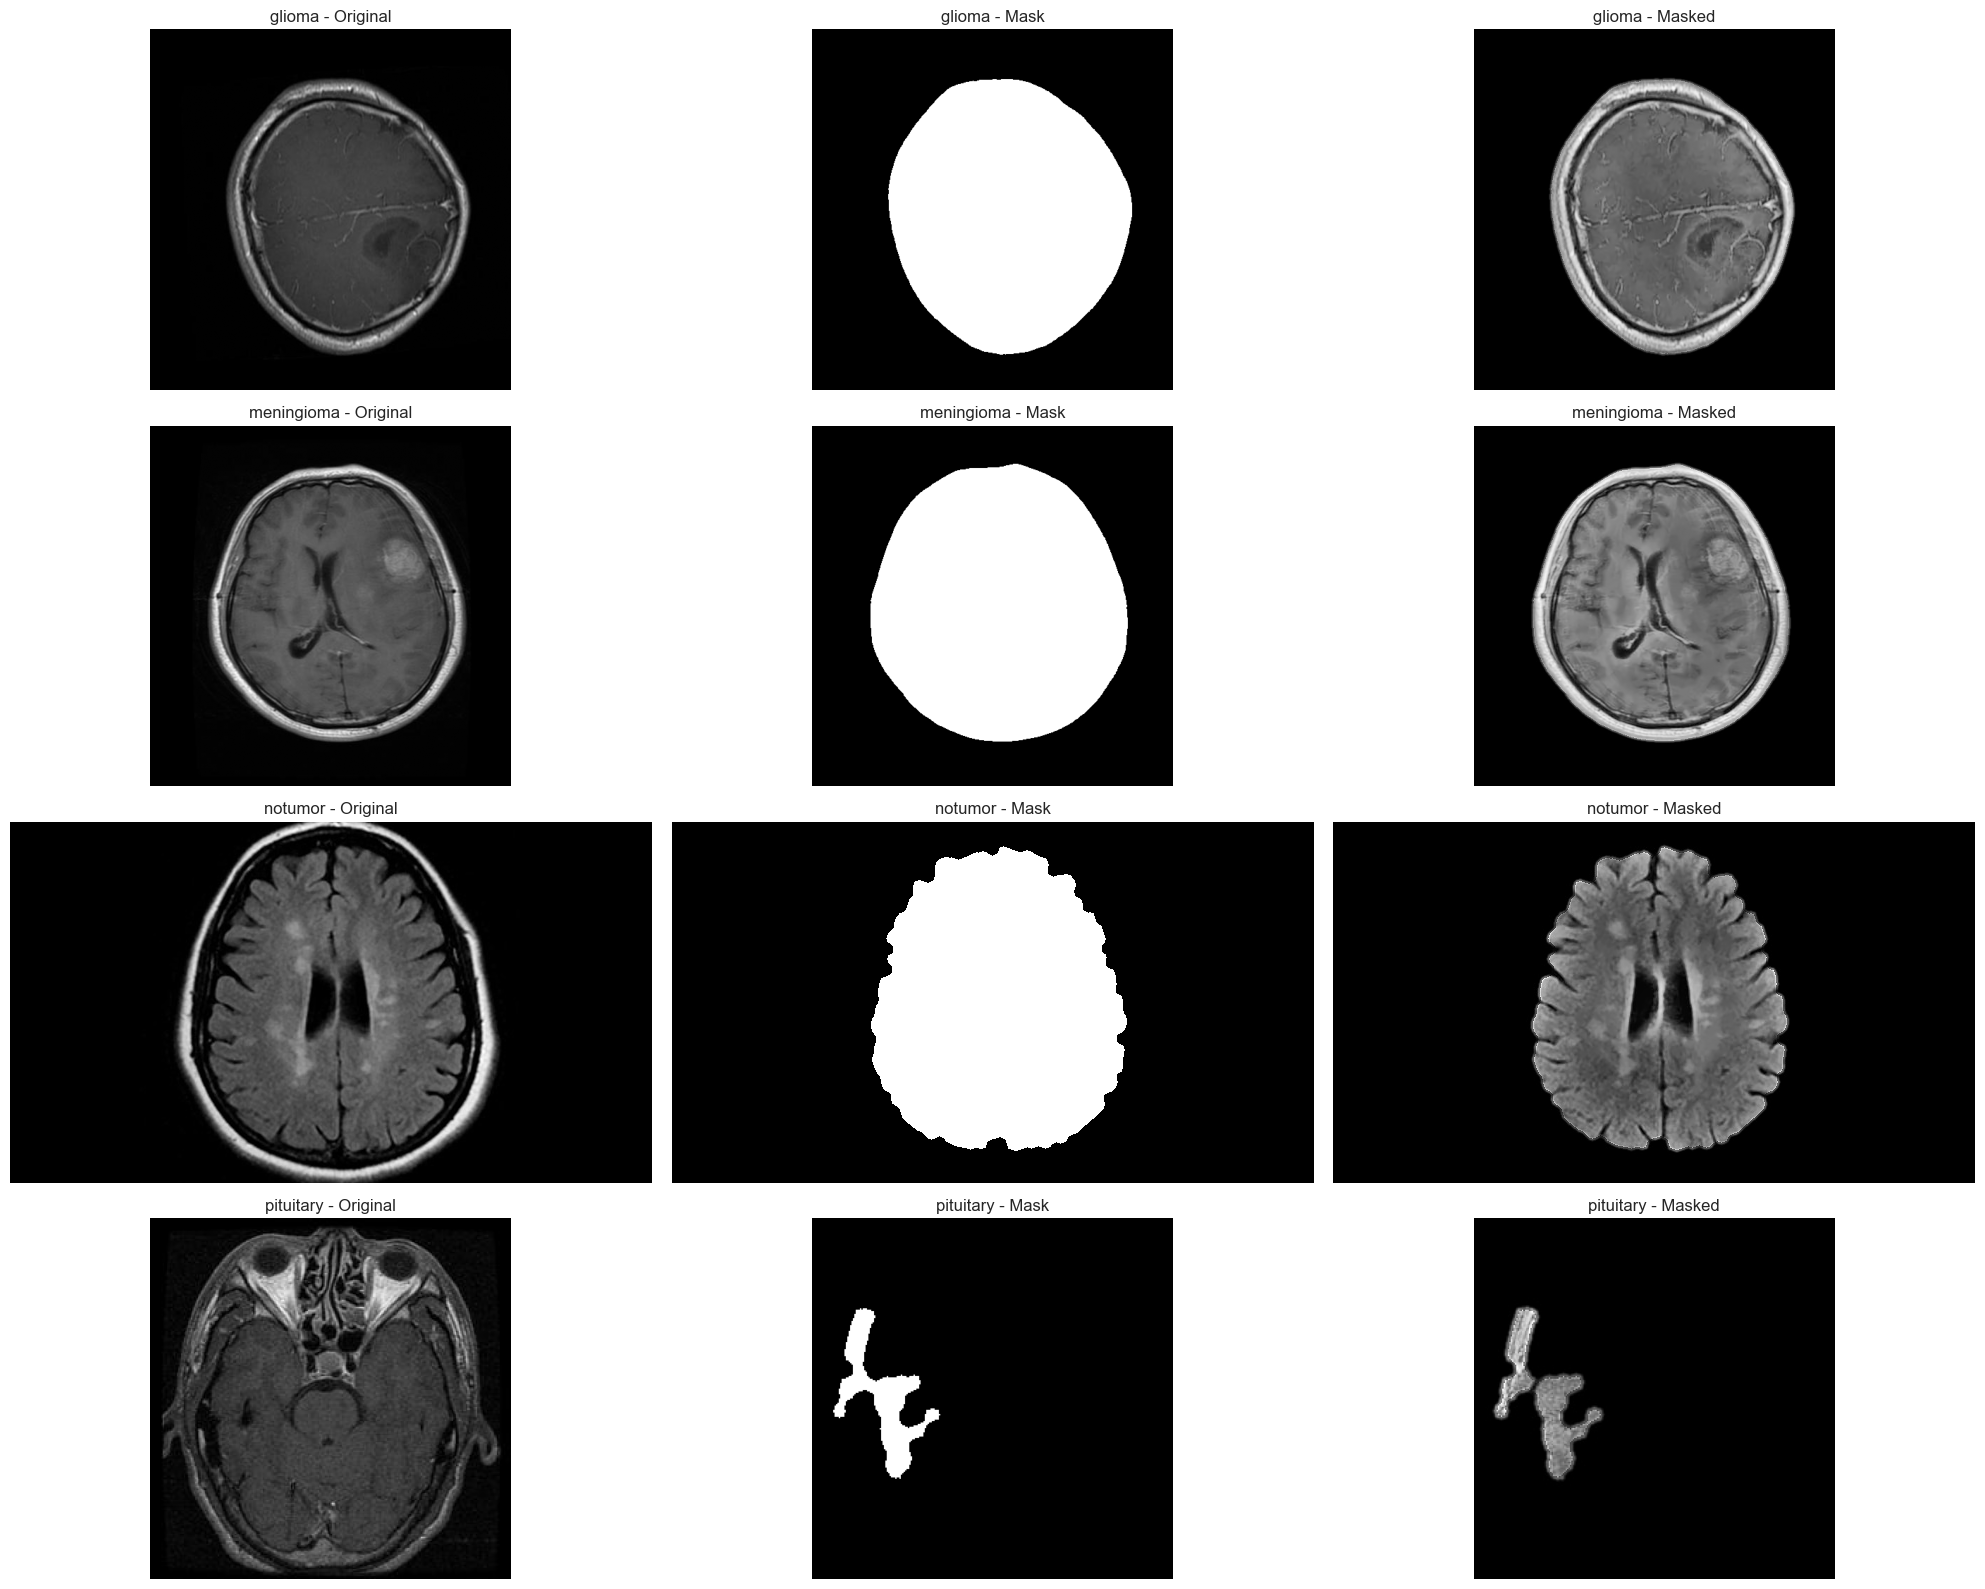

In [16]:
def visualize_results():
    """Display some example results from each class."""
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    plt.figure(figsize=(20, 4*len(classes)))
    
    for idx, class_name in enumerate(classes):
        # Get one random image from each class
        input_dir = TRAIN_PATH / class_name
        output_dir = MASK_CACHE_PATH / class_name
        
        image_files = list(input_dir.glob('*.jpg')) + list(input_dir.glob('*.png'))
        if not image_files:
            continue
            
        sample_image_path = np.random.choice(image_files)
        sample_masked_path = output_dir / sample_image_path.name
        
        # Load original and masked images
        original = load_image(sample_image_path)
        masked = load_image(sample_masked_path)
        
        # Create mask for visualization
        mask = create_brain_mask(preprocess_image(original))
        
        # Display images
        plt.subplot(len(classes), 3, idx*3 + 1)
        plt.imshow(original, cmap='gray')
        plt.title(f'{class_name} - Original')
        plt.axis('off')
        
        plt.subplot(len(classes), 3, idx*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{class_name} - Mask')
        plt.axis('off')
        
        plt.subplot(len(classes), 3, idx*3 + 3)
        plt.imshow(masked, cmap='gray')
        plt.title(f'{class_name} - Masked')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some results
visualize_results()